# We will test a model trained using filtered and clean data verses the original dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'
clean = pd.read_csv(datapath+'oldReboundClean.csv')
dirty = pd.read_csv(datapath+'oldReboundDirty.csv')
#remove junk columns
dirty = dirty.drop(columns=['Unnamed: 0'])
clean = clean.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [3]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno 

trainXC, trainYC, testXC, testYC = train_test(clean, features)
trainXD, trainYD, testXD, testYD = train_test(dirty, features)

# Train and comparison
We will used originally derived model parameters

In [5]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [6]:
modelC = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         )
modelD = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         )

In [7]:
modelC.fit(trainXC,trainYC)
modelD.fit(trainXD, trainYD)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

**Dirty data tests**

Text(0.5, 1.0, 'ROC curve for model using dirty data (AUC = 0.948)')

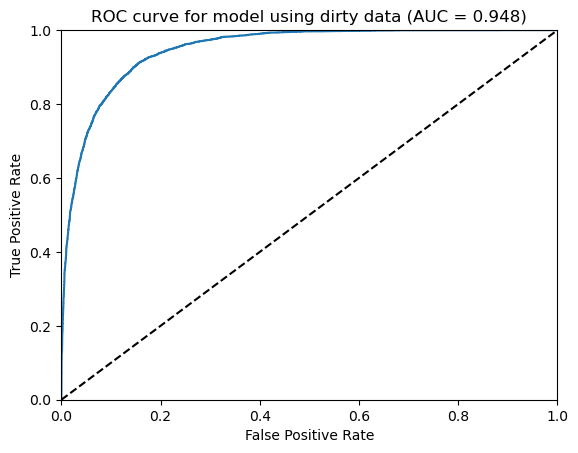

In [8]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(modelD, testXD, testYD)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve for model using dirty data (AUC = {0:.3f})'.format(roc_auc))

**Clean data tests**

Text(0.5, 1.0, 'ROC curve for model using clean data (AUC = 0.942)')

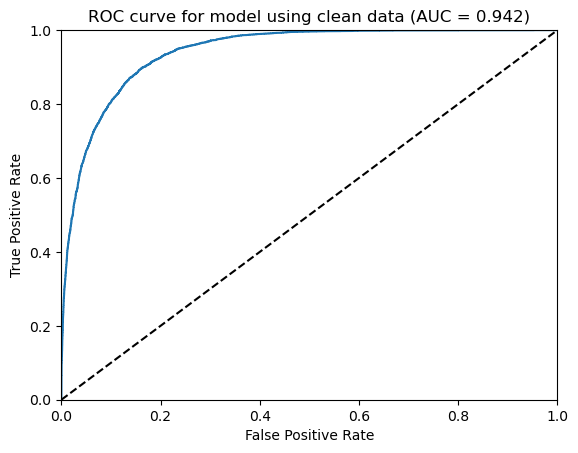

In [9]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(modelC, testXC, testYC)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve for model using clean data (AUC = {0:.3f})'.format(roc_auc))

# Results
We can see that the model using the clean dataset performs notably worse, this is expected since multiple systems are duplicated in the dirty dataset, giving the model a distinct advantage.